In [1]:
N = 8
J_value = 1
J_matrix_alpha = 1
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device( "cpu")

In [2]:
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import csv
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
np.set_printoptions(precision=6)
# initialize variables
# Q is the dimension
Q = pow(2, N)
# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')

for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [3]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis

for n in range(Q):  # n is an unused index

    # couple_num_list would be my result for each state we loop

    if len(loop_state_list)!=0: # loop for couple number for one state

        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)

        for m in range(Q): # loop for spin and spatial for all states inside the couple number list

            if m==0:

                couple_num_list_old =couple_num_list

                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # # spatial reflection
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)

                    # remove the repeated element
                    couple_num_list = np.unique(couple_num_list)
            else:

                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first
                    couple_num_list_old =couple_num_list

                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)


                        # # spatial reflection
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)

                        # remove the repeated element
                        couple_num_list = np.unique(couple_num_list)

        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())

        # remove the ones already found
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))

In [4]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)

HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

# loop each basis to fill in the diagonal elements for HA matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # loop each element inside the array
    normalization = len(state_array)

    # energy total for all the product states inside one basis

    e_tot = 0
    for j in range(len(state_array)):

        state = D2B(state_array[j])

        # loop over N sites to change the state vector to either 1 or -1

        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs

        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))

    for j in state_array:
        vector_form_basis_matrix[i][j] = 1

    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization

# loop each basis to fill in HB matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):

        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0


    # generate the vector form for the state after operrator acting on it

    vector_final_state = np.zeros(Q)

    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1

    # put back normalization factor
    vector_final_state = vector_final_state/normalization

    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):

        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product

In [5]:
B = 0.1  # !!! NEED TO BE CHANGED
# Compute the smallest eigenvalue and eigenvector
smallest_eigenvalue, smallest_eigenvector = eigsh(HA_matrix + B * HB_matrix, k=1, which='SA')

true_gs_energy = smallest_eigenvalue[0]
true_gs_vec = smallest_eigenvector[:, 0]

# Compute the largest eigenvalue
largest_eigenvalue = eigs(HA_matrix + B * HB_matrix, k=1, which='LR', return_eigenvectors=False)

E_max = largest_eigenvalue[0].real

In [6]:
true_gs_energy

-5.110650491789128

In [7]:
# get  ground state with numerically infinite large B field
# Compute the smallest eigenvalue and eigenvector
smallest_eigenvalue, smallest_eigenvector = eigsh( HB_matrix, k=1, which='SA')
temp_vec = smallest_eigenvector[:, 0]

In [8]:
# move to gpu
true_gs_vec = torch.tensor(true_gs_vec.astype(np.complex128)).to(device=device)
temp_vec = torch.tensor(temp_vec.astype(np.complex128)).to(device=device)

HA_matrix = torch.tensor(HA_matrix, dtype=torch.complex128).to(device=device)
HB_matrix = torch.tensor(HB_matrix, dtype=torch.complex128).to(device=device)
target_H = HA_matrix + B * HB_matrix

In [9]:
def get_fidelity_torch(vector1, vector2):
    overlap = torch.tensordot(vector1, vector2, dims=1)
    overlap_conj = torch.conj(overlap)
    fidelity = torch.real(overlap * overlap_conj)
    return fidelity

def get_energy_torch(matrix, vector):
    conj_vector = torch.conj(vector)
    energy = torch.real(torch.tensordot(conj_vector, torch.tensordot(matrix, vector, dims=1), dims=1))

    return energy

In [10]:
get_energy_torch(target_H,true_gs_vec).item()- true_gs_energy

-9.769962616701378e-15

In [11]:
# get fidelity for t= 0s
fidelity_t_0 = get_fidelity_torch(true_gs_vec,temp_vec)
print(fidelity_t_0)

tensor(0.0162, device='cuda:0', dtype=torch.float64)


In [12]:
# def lambda_evolve(x):
#     global fidelity
#     p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

#     for i in range(number_of_layers):
#         H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
#         exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
#         new_p = torch.matmul(exp_imgH_matrix, p)
#         p = new_p

#     # fidelity = get_fidelity_torch(true_gs_vec, p)
#     # print(fidelity)
#     energy = get_energy_torch(target_H, p)

#     return energy

In [13]:
x_10 =np.array([0.481648640320813, 0.6392949356754583, 0.4649781516823971, 0.6518475128577886, 0.7955844634336527, 0.9787585633033431, 2.01698576701233, 2.841485170761013, 1.452539894644007, 1.2302090688738114, 7.418158051701331, 3.0226608991375126, 1.3673757532433595, 0.7605554646391439, 0.5852122130608153, 0.504743518139635, 0.43352984765388014, 0.3706165784075941, 0.27863901585784, 0.1851910325406766]
               )   
x_10 = torch.tensor(x_10, dtype=torch.float64, device=device, requires_grad=False)
# 19 layers
x_20 =np.array([ 0.3014844279435918,  0.1921272709621516,  0.2818537456700573,
        0.3957882618914732,  0.4987596480845791,  0.6060442972129731,
        3.4114358609178086,  1.6028012922450432,  0.7917161550403632,
        0.783830255464649 ,  3.5655744280692376,  1.0183844667116926,
        1.1773899329966038,  1.0690133944224753,  1.1567102611048585,
        1.2521722384452187,  1.4720234839462139,  1.3080212636696467,
        1.1420371297760137, 11.705174695338204 ,  2.735656480743786 ,
        1.2739286628031565,  0.8767696497890644,  0.7036401130363863,
        0.6224299298911959,  0.5899512305559111,  0.5704521080133822,
        0.5434996050187133,  0.489695319858004 ,  0.460977378438144 ,
        0.4249340427741412,  0.372375346040481 ,  0.3337116984977648,
        0.2932959807846987,  0.2420681773890434,  0.1871137427741457,
        0.140052027751236 ,  0.1038555268509599])
x_20 = torch.tensor(x_20, dtype=torch.float64, device=device, requires_grad=False)

x_50 =np.array([0.3528703060601084, 0.2453788720438224, 1.133905920873186, 1.5550037952726907, 2.052358822406153, 0.5470043513782152, 0.8966060910858116, 0.3136741863313714, 1.679284922462869, 1.97023766620678, 0.47869232691320684, 1.8427711133405464, 1.171590508472509, 1.5359894980301556, 2.2583482229946235, 1.4211336540222097, 1.0155582429326147, 1.6159885721485754, 2.5025434610675594, 0.5162807365120907, 0.058846293277307976, 1.61462062590704, 1.6250349490711433, -0.10508831026883904, 2.936060374212869, 1.3988251894752883, 2.3135297428009056, 1.2266522031844282, 1.4013357976197423, 1.9914664948959155, 2.08403415405316, 1.3213447023572755, 2.479101918088984, 1.083108432609445, 1.421349065952447, 1.5107199094613881, 2.790380990707153, -0.8041934128016902, 3.2761968900822986, 2.385735689829477, 0.17644988489639613, 0.6588404693902001, 1.816404068128337, 2.4703282482381237, 0.9811848855149738, 1.5351550957101499, 3.788589253715731, -2.724734321812374, 2.9110284179857895, 1.3631702659363303, 6.146882549101785, 2.6035914919230154, 1.6438095381041773, 1.2196149767980058, 1.0334385157483212, 0.9952447224538475, 0.908607339377829, 0.829595708240327, 0.7203613014901799, 0.6984871022873536, 0.6051784463093001, 0.5434420828581131, 0.5185759097105764, 0.5437759497668713, 0.5044391126412987, 0.4778888280099457, 0.4429313142432216, 0.48119647769611024, 0.41717584928314183, 0.38535038527304166, 0.28340727324436976, 0.3938490678865807, 0.3652427370293282, 0.38710299361360134, 0.3489503902005756, 0.3102888928102287, 0.29452901201499293, 0.31657021259967405, 0.29462255130586473, 0.32601220141838977, 0.288818057466813, 0.21405752181989346, 0.17811860360627577, 0.16679609987799607, 0.07344765541342176, -0.029218147354816804, -0.10220418873132182, -0.05397068189585801, -0.004833200843350127, -0.031181201639468442, 0.20431184877014608, 0.01208608073461419, 0.11811405496746705, 0.13676608665166431, 0.10042557849184834, 0.14313466257581203, 0.06316100041022538, 0.08899092378861156, 0.01574850601117229, 0.03409463067629089]
)
x_50 = torch.tensor(x_50, dtype=torch.float64, device=device, requires_grad=False)
x_80 =np.array([1.3185283262155363, 1.3912867692615098, 1.5060424648394461, 1.4808578918916002, 2.02108026015372, 1.1227470403809112, 1.2343515208281644, 0.8793767647272311, 1.8070610978771873, 1.3014658129903607, 1.7859313716470995, 1.565229256075809, 1.032416359355382, 1.273104225534556, 1.503616402602846, 0.966952397719599, 1.8205140514544693, 1.4903745788817324, 1.6768173473599046, 1.3709755641247194, 1.0625015121705041, 1.151371648484852, 0.8874337147259379, 2.1508891298316626, 1.5366546381097, 0.9640704710149256, 1.7630748306652477, 1.415229897661135, 0.9167161973707662, 1.6145089703944984, 0.9530929163179287, 1.3652129000284312, 1.2031070083115756, 2.0019357157693674, 1.2247534303445964, 2.0030780750041974, 0.9069159395160943, 1.1294613247356036, 1.7015983351268167, 1.2696854755989953, 1.400498279024243, 0.7312919602106809, 2.2599498763345394, 1.5139800710719054, 0.8693839311925657, 1.5474324241464459, 2.0325069967719673, 1.9757518199778614, 1.1921455024213292, 1.2480041016643681, 2.173528442812072, 1.3566651186115268, 1.4953134963803436, 1.5056483382134258, 1.3663244918816781, 1.5988401738151297, 2.1505151829220672, 2.066602742085571, 1.3749367498716851, 1.7807339273833007, 0.9358944795762191, 0.39554784671050036, 1.998213460161461, 1.713100494395185, 1.9117361306813068, 0.8402935258933094, 1.8748349853208575, 0.9454958904201907, 2.3124457926979423, 1.2237226794969283, 1.9229324231258054, 1.0071117023918412, 1.8988700839349655, 1.6663065949620446, 0.38378372537838745, 1.9090985219084897, 1.3664326947674557, 1.613094575320484, 1.370403198568462, 1.3308031683706747, 1.8844316047252907, 1.1216467793426563, 0.8880351343937577, 0.7707175373653552, 1.0234762516020484, 0.8111769335650676, 0.6644710462736635, 0.940523433415001, 0.8594319521142699, 0.8227839814868949, 0.5620659555169448, 0.6492591514950224, 0.6181733186842526, 0.6607012601360258, 0.7726449160677641, 0.6232661137676193, 0.7792802308692939, 0.5765869943299823, 0.4956704740742871, 0.41491659246652407, 0.47454061672833914, 0.4049091797806241, 0.5394729368426142, 0.5810567409773579, 0.47551696157014123, 0.7031864814355262, 0.5385649065177178, 0.4207540383762089, 0.5065013434864443, 0.47228696341711907, 0.3583757164543054, 0.27035358233430845, 0.48059258761129936, 0.32198420164860647, 0.2496304627240936, 0.38282763246108814, 0.25913615856134586, 0.31774995071875467, 0.37385795267067273, 0.2597582518816391, 0.13138654668682687, 0.25560269934098023, 0.20765509209483596, 0.23616147842452692, 0.3353986955934178, 0.2604379269375688, 0.26547609835585256, 0.24082038474298018, 0.15438049029211376, 0.20901570418798132, 0.2945739929670995, 0.3242031520420313, 0.11602264978736228, 0.22599275556373938, 0.23105718897126265, 0.23145307707816615, 0.18991066453186772, 0.22652170642382977, 0.20808828157640552, 0.17482202782346062, 0.26251936217965405, 0.06148172222454257, 0.2757815497102569, 0.21930607366650623, 0.10200513245469259, 0.043767010742213376, 0.22268775293605192, 0.04250141618579957, 0.19119134860917458, 0.06955710639394236, 0.2549084792413403, 0.09617528240588906, 0.23851574472841938, 0.057793664696482235, 0.19170819840207937, 0.12872649065448577, 0.1554900604898718, 0.009814633166428081, -0.03288576491422699, -0.01885720381658167]
              )
x_80 = torch.tensor(x_80, dtype=torch.float64, device=device, requires_grad=False)

In [14]:
def lambda_evolve(x):
    number_of_layers = len(x)//2
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p

    fidelity = get_fidelity_torch(true_gs_vec, p)
    print(fidelity.item())
    energy = get_energy_torch(target_H, p)

    return energy.item()

In [15]:
def get_energy_list(x):
    number_of_layers = len(x)//2
    energy_list = []
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p
        energy = get_energy_torch(target_H, p)
        energy_list.append(energy.item())

    return energy_list

In [16]:
def get_fidelity_matrix(x):
    number_of_layers = len(x)//2
    fidelity_matrix = []
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        # evolve the state, loop each layers
        H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p
        # now i have my inst state

        # loop states to get excited states
        fidelity_list = []
        for j in range(1,couple_dimen): # start with 1, only care about excitation

          # get excited state
          eigenvalues, eigenvectors = torch.linalg.eigh(HA_matrix + B * HB_matrix)

          excited_state = eigenvectors.T[j]

          fidelity = get_fidelity_torch(excited_state, p).item()
          #print(fidelity)

          fidelity_list.append(fidelity)

        fidelity_matrix.append(fidelity_list)

    return fidelity_matrix

In [17]:
def get_fidelity_list(x):
    number_of_layers = len(x)//2
    fidelity_list = []
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        # evolve the state, loop each layers
        H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p
        # now i have my inst state


        fidelity = get_fidelity_torch(true_gs_vec, p).item()
        #print(fidelity)

        fidelity_list.append(fidelity)


    return fidelity_list

In [18]:
# fidelity_list_10 = get_fidelity_list(x_10)
# fidelity_list_20 = get_fidelity_list(x_20)
# fidelity_list_50 = get_fidelity_list(x_50)
# fidelity_list_80 = get_fidelity_list(x_80)
# # Save the lists to CSV files
# def save_fidelity_list_to_csv(filename, fidelity_list):
#     with open(filename, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(fidelity_list)  # Write the list as a single row

# # Save each list into its own CSV file
# save_fidelity_list_to_csv('fidelity_list_10.csv', fidelity_list_10)
# save_fidelity_list_to_csv('fidelity_list_20.csv', fidelity_list_20)
# save_fidelity_list_to_csv('fidelity_list_50.csv', fidelity_list_50)
# save_fidelity_list_to_csv('fidelity_list_80.csv', fidelity_list_80)


In [19]:
# Read the lists from CSV files
def load_fidelity_list_from_csv(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        # Read the first (and only) row, convert each item to float
        return [float(item) for item in next(reader)]

# Load each list from its respective CSV file
fidelity_list_10 = load_fidelity_list_from_csv('fidelity_list_10.csv')
fidelity_list_20 = load_fidelity_list_from_csv('fidelity_list_20.csv')
fidelity_list_50 = load_fidelity_list_from_csv('fidelity_list_50.csv')
fidelity_list_80 = load_fidelity_list_from_csv('fidelity_list_80.csv')


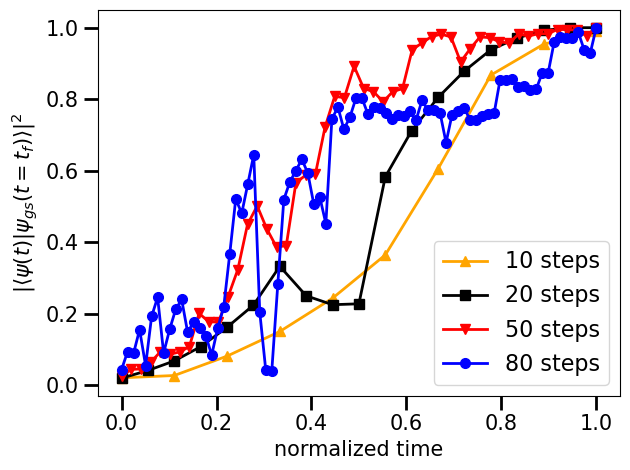

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define markersize
markersize = 7

# Plotting the lines with different symbols
plt.plot(np.linspace(0, 1, len(fidelity_list_10)), fidelity_list_10, color='orange', lw=2, marker='^', markersize=markersize, label='10 steps')
plt.plot(np.linspace(0, 1, len(fidelity_list_20)), fidelity_list_20, color='black', lw=2, marker='s', markersize=markersize, label='20 steps')
plt.plot(np.linspace(0, 1, len(fidelity_list_50)), fidelity_list_50, color='red', lw=2, marker='v', markersize=markersize, label='50 steps')
plt.plot(np.linspace(0, 1, len(fidelity_list_80)), fidelity_list_80, color='blue', lw=2, marker='o', markersize=markersize, label='80 steps')
# Adding labels and adjusting plot parameters
plt.xlabel('normalized time', size=15)
plt.ylabel(r'$|\langle \psi(t) | \psi_{gs}(t=t_f) \rangle|^2$', color='black', size=15)
plt.tick_params(axis='both', which='major', labelsize=15, length=10, width=2)
# Adjust legend for clarity
plt.legend(fontsize=16)
# Save the plot
plt.tight_layout()
plt.savefig('gs_evolution.png')
plt.show()


In [21]:
# fidelity_matrix = get_fidelity_matrix(x_80)
# fidelity_matrix = np.array(fidelity_matrix)

# import csv
# import numpy as np

# # Save the matrix to a CSV file
# def save_fidelity_matrix_to_csv(filename, fidelity_matrix):
#     with open(filename, 'w', newline='') as file:
#         writer = csv.writer(file)
#         # Write each row of the matrix to the CSV file
#         for row in fidelity_matrix:
#             writer.writerow(row)

# # Save the fidelity matrix to 'fidelity_matrix.csv'
# save_fidelity_matrix_to_csv('fidelity_matrix.csv', fidelity_matrix)


In [22]:
# Read the matrix from a CSV file
def load_fidelity_matrix_from_csv(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        # Convert each row to a list of floats
        return np.array([[float(item) for item in row] for row in reader])

# Load the fidelity matrix from 'fidelity_matrix.csv'
fidelity_matrix = load_fidelity_matrix_from_csv('fidelity_matrix.csv')
# after transpose, fidelity_matrix[0] is the fidelity for the first exctied state along the time evolution
fidelity_matrix = fidelity_matrix.T

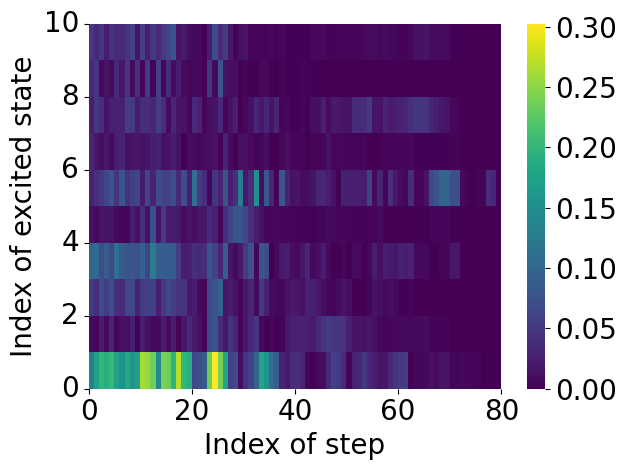

In [23]:
import seaborn as sns

ax = sns.heatmap(fidelity_matrix[:10], cmap='viridis', cbar_kws={'ticks': [0, 0.05,0.1, 0.15,0.2,0.25, 0.3], 'shrink': 1})
ax.collections[0].colorbar.ax.tick_params(labelsize=20)  # Set colorbar tick labels size

# plt.title('Fidelity of exctied states ',size=16)

# Customize ticks
ax.set_xticks([0,20,40,60,80])
ax.set_xticklabels(['0', '20', '40', '60', '80'], fontsize=20, rotation=0)


# Customize ticks
ax.set_yticks([0,2,4,6,8,10])
ax.set_yticklabels(['0', '2','4','6','8' ,'10'], fontsize=20, rotation=0)

ax.set_xlabel('Index of step', fontsize=20)
ax.set_ylabel('Index of excited state', fontsize=20)

# Invert y-axis
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('diabatic_excitation')
plt.show()
